#  Comparative Implementation of GAN Variants with VAE-GANs


# VAEs and Latent Space

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - kl_loss: 15.7490 - loss: 250.8092 - reconstruction_loss: 235.0603
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - kl_loss: 4.7332 - loss: 174.8674 - reconstruction_loss: 170.1342
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - kl_loss: 4.8850 - loss: 167.7067 - reconstruction_loss: 162.8217
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - kl_loss: 4.9843 - loss: 165.2509 - reconstruction_loss: 160.2666
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - kl_loss: 5.0928 - loss: 163.4111 - reconstruction_loss: 158.3183
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - kl_loss: 5.1592 - loss: 161.9874 - reconstruction_loss: 156.8283
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - kl_loss: 5.2818 - loss: 161.0509 - reconstruction_loss: 155.7691
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - kl_loss: 5.3591 - loss: 159.6142 - reconstruction_loss: 154.2551
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━

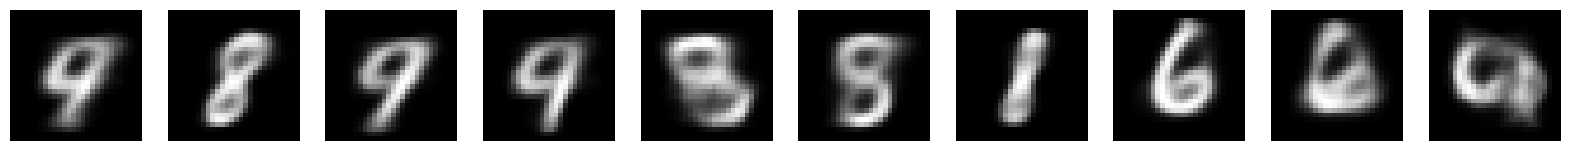

In [13]:
# Comparative Implementation of GAN Variants with VAE-GANs
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

# Load and normalize the MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

latent_dim = 2  # Try changing to 10 or 20 to experiment

# Encoder
class Encoder(Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(256, activation='relu')
        self.z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense1(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        return z_mean, z_log_var

# Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Decoder
class Decoder(Model):
    def __init__(self):
        super().__init__()
        self.dense1 = layers.Dense(256, activation='relu')
        self.dense2 = layers.Dense(28 * 28, activation='sigmoid')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.reshape(x)

# VAE model
class VAE(Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampling()

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler((z_mean, z_log_var))
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2))
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Instantiate and train the model
encoder = Encoder(latent_dim)
decoder = Decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

# Generate samples
def generate_and_plot_images(model, n=10):
    z = tf.random.normal(shape=(n, latent_dim))
    generated = model.decoder(z)
    generated = generated.numpy()
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

generate_and_plot_images(vae)


# Regularization & Stability Techniques

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
import os

# Create directories for results
os.makedirs("vae_images", exist_ok=True)
os.makedirs("gan_images", exist_ok=True)

# Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
lr = 0.0002
latent_dim = 100
img_shape = (1, 28, 28)
img_size = np.prod(img_shape)
epochs = 50 # Increase for better results, 50 is good for a demo

# Data Loader (Fashion-MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
dataloader = DataLoader(
    datasets.FashionMNIST(
        "../data",
        train=True,
        download=True,
        transform=transform,
    ),
    batch_size=batch_size,
    shuffle=True,
)

In [ ]:
# --- Vanilla VAE ---
class VanillaVAE(nn.Module):
    def __init__(self):
        super(VanillaVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(img_size, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 256), nn.LeakyReLU(0.2)
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, img_size), nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)
        h = self.encoder(x_flat)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        img_recon = self.decoder(z)
        return img_recon.view(x.size()), mu, logvar

# --- Regularized VAE (BatchNorm + Dropout) ---
class RegularizedVAE(nn.Module):
    def __init__(self):
        super(RegularizedVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(img_size, 512), nn.BatchNorm1d(512), nn.LeakyReLU(0.2), nn.Dropout(0.3),
            nn.Linear(512, 256), nn.BatchNorm1d(256), nn.LeakyReLU(0.2), nn.Dropout(0.3)
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.BatchNorm1d(256), nn.LeakyReLU(0.2),
            nn.Linear(256, 512), nn.BatchNorm1d(512), nn.LeakyReLU(0.2),
            nn.Linear(512, img_size), nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)
        h = self.encoder(x_flat)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        img_recon = self.decoder(z)
        return img_recon.view(x.size()), mu, logvar

def vae_loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x.view(-1, img_size), x.view(-1, img_size), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train_vae(model, dataloader, epochs, model_name):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    losses = []
    print(f"--- Training {model_name} ---")
    for epoch in range(epochs):
        epoch_loss = 0
        for i, (imgs, _) in enumerate(dataloader):
            imgs = imgs.to(device)
            recon_imgs, mu, logvar = model(imgs)

            loss = vae_loss_function(recon_imgs, imgs, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader.dataset)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
        
        # Save generated images
        with torch.no_grad():
            z = torch.randn(64, latent_dim).to(device)
            sample = model.decoder(z).view(64, 1, 28, 28)
            save_image(sample, f"vae_images/{model_name}_epoch_{epoch+1}.png", normalize=True)
            
    return losses

# Train models (using fewer epochs for quick demo)
vae_epochs = 15
vanilla_vae = VanillaVAE()
regularized_vae = RegularizedVAE()

vanilla_losses = train_vae(vanilla_vae, dataloader, vae_epochs, "VanillaVAE")
regularized_losses = train_vae(regularized_vae, dataloader, vae_epochs, "RegularizedVAE")


--- Training VanillaVAE ---
Epoch [1/15], Loss: 150.9795


In [ ]:
# --- Base GAN (unstable) ---
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 1024), nn.LeakyReLU(0.2),
            nn.Linear(1024, img_size), nn.Tanh()
        )
    def forward(self, z):
        return self.model(z).view(-1, *img_shape)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 1) # No sigmoid for WGAN-GP loss
        )
    def forward(self, img):
        return self.model(img.view(img.size(0), -1))

# --- Gradient Penalty Calculation ---
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    
    # Use a dummy tensor of ones as the gradients for the backward pass
    fake = torch.ones(real_samples.size(0), 1).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# --- Training Loop ---
def train_gan(use_stabilization, epochs, model_name):
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    
    # Note on Spectral Norm:
    # A great alternative is Spectral Norm. You'd apply it like this:
    # nn.utils.spectral_norm(nn.Linear(img_size, 512))
    # It often replaces GP and BatchNorm in the discriminator.

    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))
    
    g_losses, d_losses = [], []
    lambda_gp = 10 # Gradient penalty coefficient

    print(f"\n--- Training {model_name} ---")
    for epoch in range(epochs):
        for i, (real_imgs, _) in enumerate(dataloader):
            real_imgs = real_imgs.to(device)
            
            # -----------------
            #  Train Discriminator
            # -----------------
            optimizer_D.zero_grad()
            
            z = torch.randn(real_imgs.size(0), latent_dim).to(device)
            fake_imgs = generator(z).detach()

            real_validity = discriminator(real_imgs)
            fake_validity = discriminator(fake_imgs)
            
            if use_stabilization:
                # WGAN-GP Loss with Gradient Penalty
                gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
                d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
                
                # Label Smoothing is applied implicitly by the WGAN-GP loss structure,
                # as it doesn't use a sigmoid and cross-entropy.
                # If using BCE loss, you'd do:
                # real_labels = torch.full((real_imgs.size(0), 1), 0.9).to(device)
                # fake_labels = torch.full((real_imgs.size(0), 1), 0.1).to(device)
            else:
                # Standard GAN loss (non-saturating)
                d_loss_real = torch.mean(nn.functional.relu(1.0 - real_validity))
                d_loss_fake = torch.mean(nn.functional.relu(1.0 + fake_validity))
                d_loss = d_loss_real + d_loss_fake
                
            d_loss.backward()
            optimizer_D.step()

            # -----------------
            #  Train Generator
            # -----------------
            # Train generator every n_critic steps
            if i % 5 == 0:
                optimizer_G.zero_grad()
                gen_imgs = generator(z)
                g_loss = -torch.mean(discriminator(gen_imgs))
                g_loss.backward()
                optimizer_G.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        
        print(f"Epoch [{epoch+1}/{epochs}] D loss: {d_loss.item():.4f}, G loss: {g_loss.item():.4f}")

        # Save generated images
        fixed_z = torch.randn(64, latent_dim).to(device)
        with torch.no_grad():
            sample = generator(fixed_z)
            save_image(sample, f"gan_images/{model_name}_epoch_{epoch+1}.png", normalize=True)

    return g_losses, d_losses

# Train GANs (using fewer epochs for quick demo)
gan_epochs = 25
base_g_loss, base_d_loss = train_gan(use_stabilization=False, epochs=gan_epochs, model_name="BaseGAN")
stable_g_loss, stable_d_loss = train_gan(use_stabilization=True, epochs=gan_epochs, model_name="StableGAN_GP")

In [ ]:
# --- VAE Visualization ---
plt.figure(figsize=(10, 5))
plt.title("VAE Training Loss Comparison")
plt.plot(vanilla_losses, label="Vanilla VAE Loss")
plt.plot(regularized_losses, label="Regularized VAE (BN+Dropout) Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

print("Displaying VAE generated samples (Regularized vs. Vanilla)...")
# Display final generated images
vanilla_img = plt.imread(f'vae_images/VanillaVAE_epoch_{vae_epochs}.png')
regularized_img = plt.imread(f'vae_images/RegularizedVAE_epoch_{vae_epochs}.png')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(vanilla_img)
axes[0].set_title(f"Vanilla VAE after {vae_epochs} epochs")
axes[0].axis('off')
axes[1].imshow(regularized_img)
axes[1].set_title(f"Regularized VAE after {vae_epochs} epochs")
axes[1].axis('off')
plt.show()

# --- GAN Visualization ---
plt.figure(figsize=(10, 5))
plt.title("GAN Training Loss Comparison")
plt.plot(base_g_loss, label="Base GAN Generator Loss", alpha=0.7)
plt.plot(base_d_loss, label="Base GAN Discriminator Loss", alpha=0.7)
plt.plot(stable_g_loss, label="Stable GAN-GP Generator Loss", linewidth=2)
plt.plot(stable_d_loss, label="Stable GAN-GP Discriminator Loss", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.ylim(-50, 50) # Clip y-axis to see the stable part clearly
plt.grid(True)
plt.show()

print("\nDisplaying GAN generated samples (Stable vs. Base)...")
print("Observe the diversity. A collapsed model will show very few types of items.")
# Display final generated images
base_gan_img = plt.imread(f'gan_images/BaseGAN_epoch_{gan_epochs}.png')
stable_gan_img = plt.imread(f'gan_images/StableGAN_GP_epoch_{gan_epochs}.png')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(base_gan_img)
axes[0].set_title(f"Base GAN after {gan_epochs} epochs")
axes[0].axis('off')
axes[1].imshow(stable_gan_img)
axes[1].set_title(f"Stable GAN (WGAN-GP) after {gan_epochs} epochs")
axes[1].axis('off')
plt.show()

# Exploring Loss Functions in Generative Adversarial Networks: A Comparative Implementation of Standard GAN and WGAN Architectures

# Basic GAN Implementation using Binary Cross-Entropy (BCE) Loss

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1, Generator Loss: -35.2717, Discriminator Loss: -2.0599


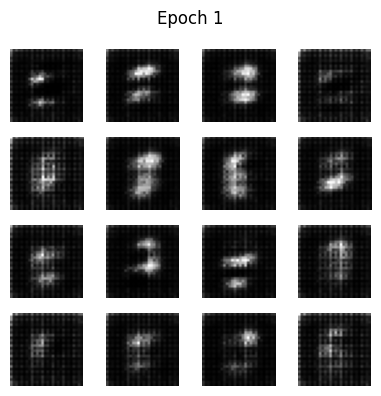

Epoch 2, Generator Loss: -48.4879, Discriminator Loss: -1.1932


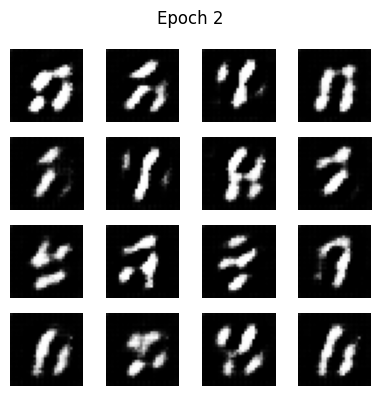

Epoch 3, Generator Loss: -50.6049, Discriminator Loss: 0.3198


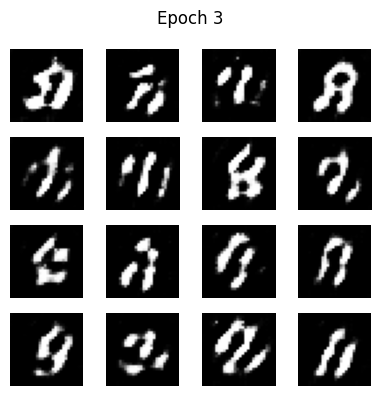

Epoch 4, Generator Loss: -42.7630, Discriminator Loss: 0.1545


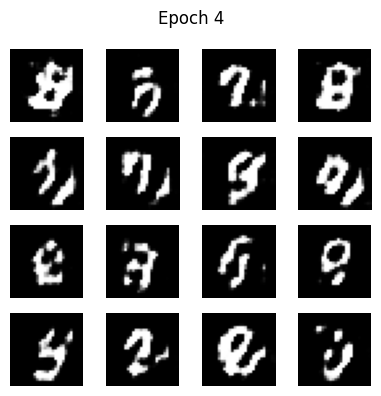

Epoch 5, Generator Loss: -33.7430, Discriminator Loss: 0.1755


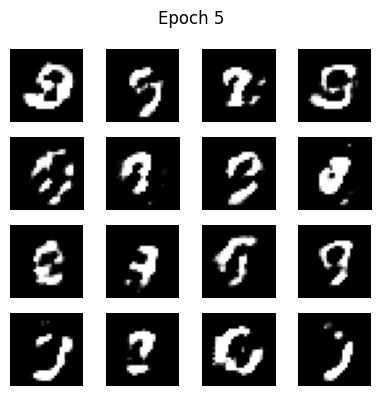

Epoch 6, Generator Loss: -32.3185, Discriminator Loss: 0.1642


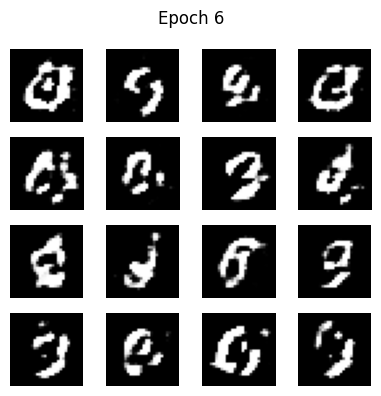

Epoch 7, Generator Loss: -27.2938, Discriminator Loss: 0.0989


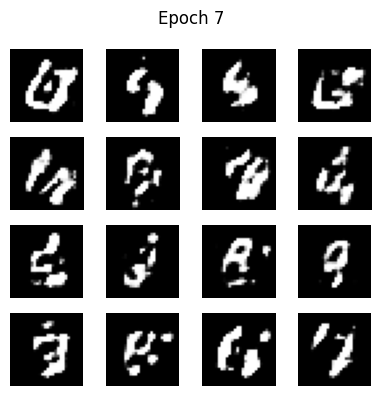

Epoch 8, Generator Loss: -23.8925, Discriminator Loss: 0.0523


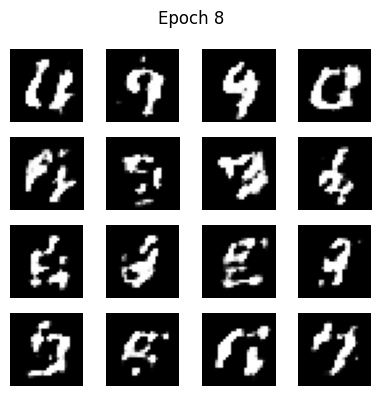

Epoch 9, Generator Loss: -20.0965, Discriminator Loss: -0.2630


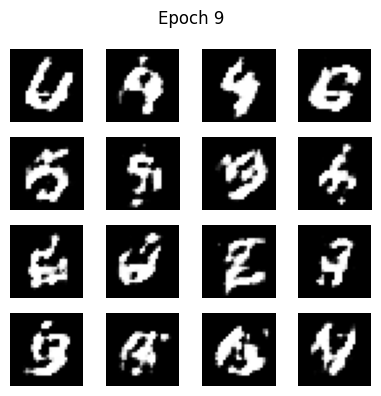

Epoch 10, Generator Loss: -22.2844, Discriminator Loss: -0.0664


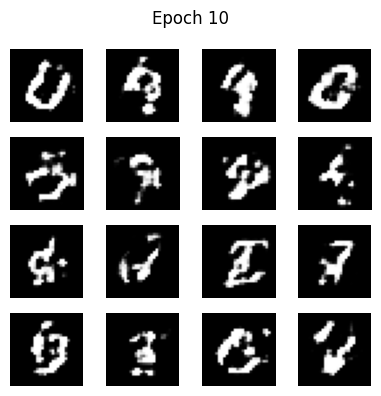

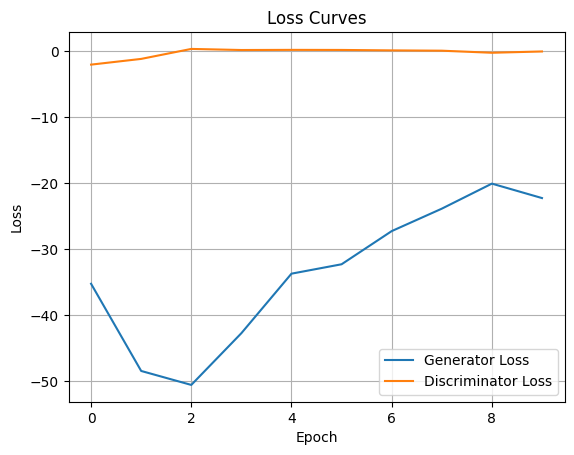

In [1]:
# GAN Implementation in TensorFlow
# Goal: Learn how GANs work by building one that generates handwritten digits (MNIST dataset)

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load and normalize the MNIST dataset to values in range [-1, 1]
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = (train_images.reshape(-1, 28, 28, 1).astype("float32") - 127.5) / 127.5
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Create batches of shuffled training data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Define the Generator network
# This network takes in random noise and learns to produce realistic-looking images

def make_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=2, padding="same", use_bias=False, activation="tanh")
    ])
    return model

# Define the Discriminator network
# This network takes in an image and outputs whether it's real or fake

def make_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=2, padding="same", input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Binary Cross Entropy loss: commonly used in GANs
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define loss functions for both BCE and Wasserstein options

def generator_loss_bce(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss_bce(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss_wass(fake_output):
    return -tf.reduce_mean(fake_output)

def discriminator_loss_wass(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

# Optimizers for both networks
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

# Training setup parameters
EPOCHS = 10
noise_dim = 100
seed = tf.random.normal([16, noise_dim])  # Used to visualize progress after every epoch
USE_WASSERSTEIN = True  # this is to try Wasserstein loss instead of BCE

# Create models
generator = make_generator()
discriminator = make_discriminator()

# One training step - applies gradients to both networks
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        if USE_WASSERSTEIN:
            gen_loss = generator_loss_wass(fake_output)
            disc_loss = discriminator_loss_wass(real_output, fake_output)
        else:
            gen_loss = generator_loss_bce(fake_output)
            disc_loss = discriminator_loss_bce(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Function to display generated images

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")

    plt.suptitle(f"Epoch {epoch}")
    plt.tight_layout()
    plt.show()

# Complete training loop

def train(dataset, epochs):
    gen_losses = []
    disc_losses = []
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)

        print(f"Epoch {epoch + 1}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}")
        generate_and_save_images(generator, epoch + 1, seed)

    return gen_losses, disc_losses

# Start training
losses_gen, losses_disc = train(train_dataset, EPOCHS)

# Plot loss curves after training is done
plt.plot(losses_gen, label="Generator Loss")
plt.plot(losses_disc, label="Discriminator Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


# GAN Implementation with Wasserstein Loss (WGAN)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1, Generator Loss: 0.6610, Discriminator Loss: 1.1705


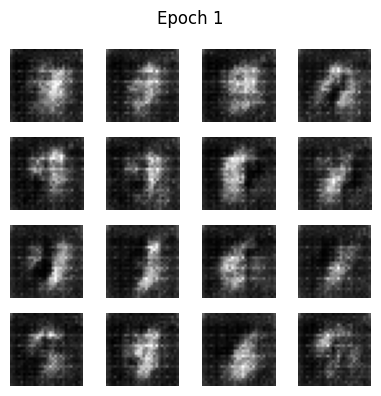

Epoch 2, Generator Loss: 0.6387, Discriminator Loss: 1.3032


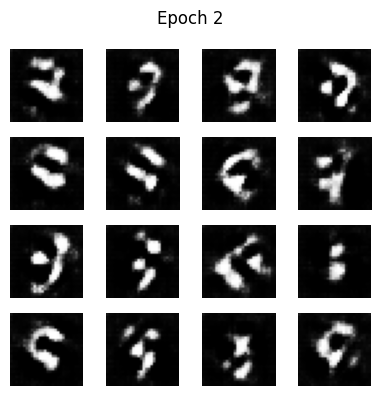

Epoch 3, Generator Loss: 0.7919, Discriminator Loss: 1.3521


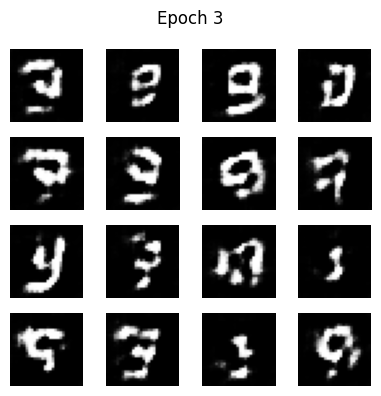

Epoch 4, Generator Loss: 0.6402, Discriminator Loss: 1.3648


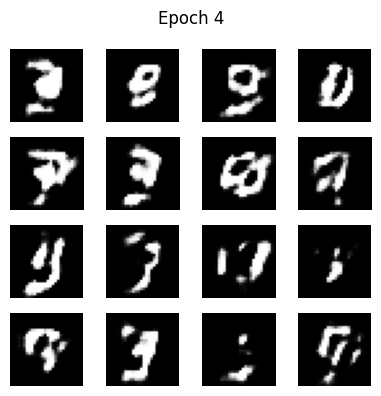

Epoch 5, Generator Loss: 0.7372, Discriminator Loss: 1.3490


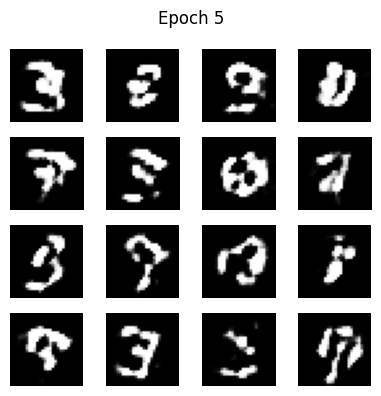

Epoch 6, Generator Loss: 0.8154, Discriminator Loss: 1.3496


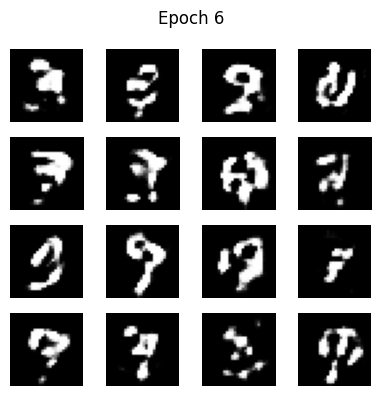

Epoch 7, Generator Loss: 0.7609, Discriminator Loss: 1.3261


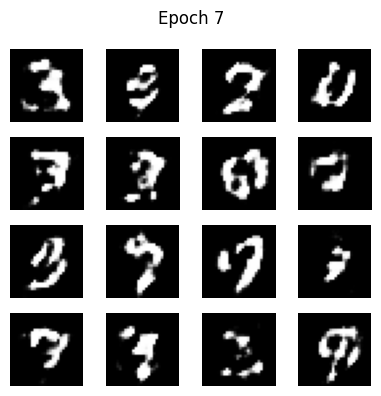

Epoch 8, Generator Loss: 0.8345, Discriminator Loss: 1.3237


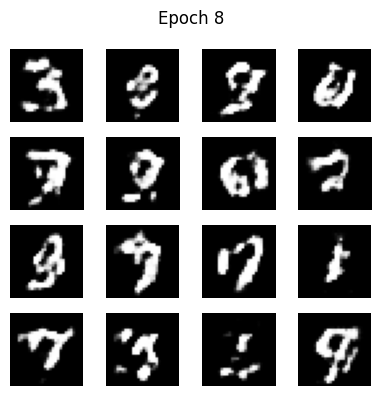

Epoch 9, Generator Loss: 0.7010, Discriminator Loss: 1.3068


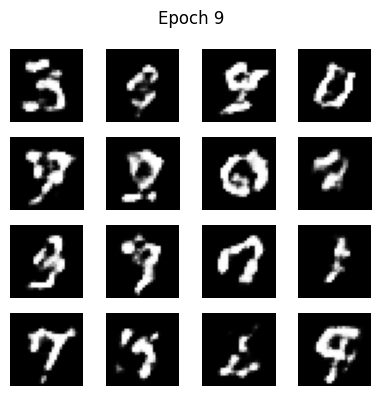

Epoch 10, Generator Loss: 0.7110, Discriminator Loss: 1.3263


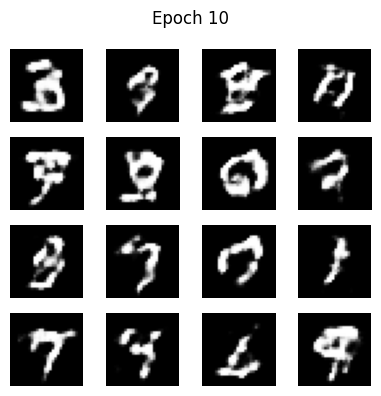

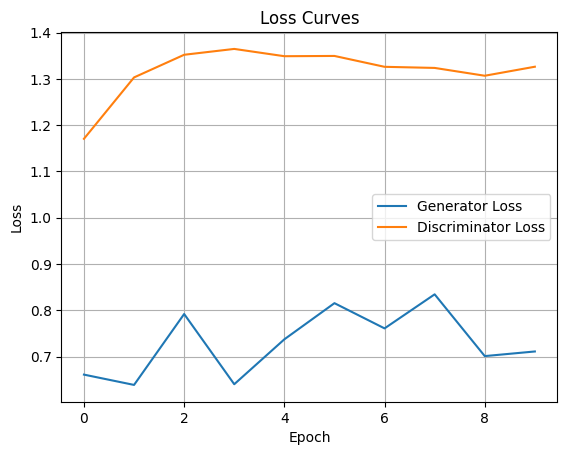

In [1]:
# GAN Implementation in TensorFlow
# Goal: Learn how GANs work by building one that generates handwritten digits (MNIST dataset)

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load and normalize the MNIST dataset to values in range [-1, 1]
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = (train_images.reshape(-1, 28, 28, 1).astype("float32") - 127.5) / 127.5
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Create batches of shuffled training data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Define the Generator network
# This network takes in random noise and learns to produce realistic-looking images

def make_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=2, padding="same", use_bias=False, activation="tanh")
    ])
    return model

# Define the Discriminator network
# This network takes in an image and outputs whether it's real or fake

def make_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=2, padding="same", input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Binary Cross Entropy loss: commonly used in GANs
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define loss functions for both BCE and Wasserstein options

def generator_loss_bce(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss_bce(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss_wass(fake_output):
    return -tf.reduce_mean(fake_output)

def discriminator_loss_wass(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

# Optimizers for both networks
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

# Training setup parameters
EPOCHS = 10
noise_dim = 100
seed = tf.random.normal([16, noise_dim])  # Used to visualize progress after every epoch
USE_WASSERSTEIN = False  # Toggle this to try Wasserstein loss instead of BCE

# Create models
generator = make_generator()
discriminator = make_discriminator()

# One training step - applies gradients to both networks
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        if USE_WASSERSTEIN:
            gen_loss = generator_loss_wass(fake_output)
            disc_loss = discriminator_loss_wass(real_output, fake_output)
        else:
            gen_loss = generator_loss_bce(fake_output)
            disc_loss = discriminator_loss_bce(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Function to display generated images

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")

    plt.suptitle(f"Epoch {epoch}")
    plt.tight_layout()
    plt.show()

# Complete training loop

def train(dataset, epochs):
    gen_losses = []
    disc_losses = []
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)

        print(f"Epoch {epoch + 1}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}")
        generate_and_save_images(generator, epoch + 1, seed)

    return gen_losses, disc_losses

# Start training
losses_gen, losses_disc = train(train_dataset, EPOCHS)

# Plot loss curves after training is done
plt.plot(losses_gen, label="Generator Loss")
plt.plot(losses_disc, label="Discriminator Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
